In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from scipy import signal
from scipy.signal import find_peaks

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dftraintest/test_lab1.csv
/kaggle/input/dftraintest/train_lab1.csv
/kaggle/input/dapprojekt24-1/train.csv
/kaggle/input/dapprojekt24-1/test.csv


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
df_train = pd.read_csv("/kaggle/input/dftraintest/train_lab1.csv")
df_train.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Target,Id
0,2010-01-04,MMM,53.295380,83.019997,83.449997,82.669998,83.089996,3043700.0,0,0
1,2010-01-05,MMM,52.961575,82.500000,83.230003,81.699997,82.800003,2847000.0,0,1
2,2010-01-06,MMM,53.712681,83.669998,84.599998,83.510002,83.879997,5268500.0,0,2
3,2010-01-07,MMM,53.751179,83.730003,83.760002,82.120003,83.320000,4470100.0,0,3
4,2010-01-08,MMM,54.129955,84.320000,84.320000,83.300003,83.690002,3405800.0,0,4


In [7]:
df_test = pd.read_csv("/kaggle/input/dftraintest/test_lab1.csv")
df_test.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Id
0,2020-01-02,MMM,149.672821,180.000000,180.009995,177.139999,177.679993,3601700.0,0
1,2020-01-03,MMM,148.383942,178.449997,178.660004,175.630005,177.020004,2466900.0,1
2,2020-01-06,MMM,148.525299,178.619995,178.710007,176.350006,177.149994,1998000.0,2
3,2020-01-07,MMM,147.926636,177.899994,178.509995,176.820007,178.279999,2173000.0,3
4,2020-01-08,MMM,150.196686,180.630005,181.500000,177.649994,178.000000,2758300.0,4


# DATA PREPARATION 
- find seasonality by using "Adj Close" feature

In [7]:
stocks_train = df_train["Symbol"].unique()
print(stocks_train)

['MMM' 'AOS' 'ACN' 'AES' 'A' 'AKAM' 'ALB' 'ALLE' 'LNT' 'GOOGL' 'MO' 'AMZN'
 'AXP' 'AWK' 'AME' 'ANSS' 'APA' 'AAPL' 'AMAT' 'ADM' 'ANET' 'AIZ' 'T' 'BKR'
 'BALL' 'BAC' 'BBY' 'BIIB' 'BLK' 'BMY' 'AVGO' 'BG' 'CPB' 'CAH' 'CBOE'
 'CHRW' 'CHTR' 'CMG' 'CINF' 'CSCO' 'CFG' 'CME' 'CMS' 'KO' 'CAG' 'ED' 'STZ'
 'CTVA' 'CTRA' 'CMI' 'DVA' 'DE' 'XRAY' 'FANG' 'DLR' 'DFS' 'DPZ' 'DHI'
 'DTE' 'DUK' 'EBAY' 'EMR' 'ENPH' 'EOG' 'EQIX' 'ESS' 'EL' 'EVRG' 'ES'
 'EXPD' 'EXR' 'FFIV' 'FAST' 'FIS' 'FE' 'FLT' 'FTV' 'FOXA' 'FCX' 'IT' 'GEN'
 'GNRC' 'GM' 'GPC' 'GL' 'GS' 'HAS' 'PEAK' 'HSY' 'HES' 'HLT' 'HST' 'HBAN'
 'IBM' 'ILMN' 'PODD' 'INTC' 'IFF' 'IP' 'ISRG' 'IVZ' 'INVH' 'IQV' 'JNJ'
 'KDP' 'KEY' 'KEYS' 'KMB' 'KIM' 'KMI' 'KR' 'LVS' 'LDOS' 'LIN' 'LMT' 'LYB'
 'MPC' 'MKTX' 'MMC' 'MCD' 'MAA' 'MHK' 'TAP' 'MPWR' 'MS' 'MOS' 'MSI' 'NDAQ'
 'NEE' 'NDSN' 'NOC' 'NRG' 'NVDA' 'NVR' 'ORCL' 'PKG' 'PARA' 'PH' 'PAYX'
 'PNR' 'PCG' 'PSX' 'PNW' 'PNC' 'PGR' 'PRU' 'PTC' 'PSA' 'PHM' 'PWR' 'QCOM'
 'DGX' 'RL' 'RF' 'RSG' 'RMD' 'RVTY' 'RHI' 'ROL' 'ROST

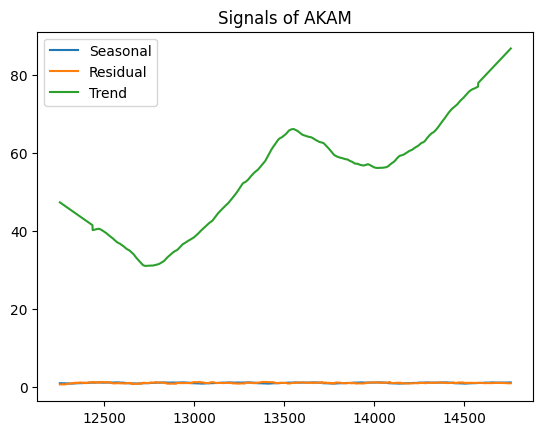

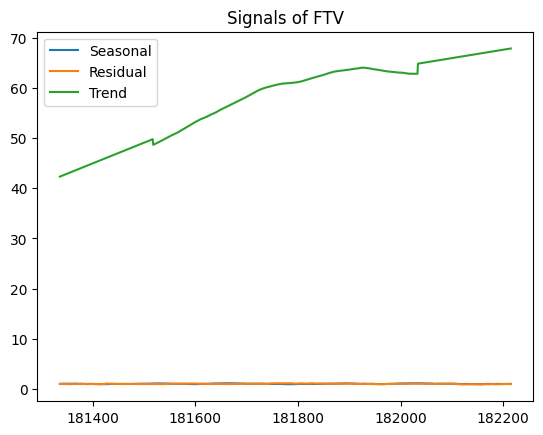

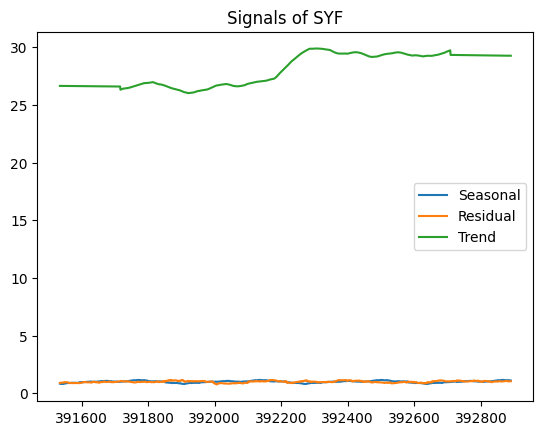

In [9]:
seasonal_stocks = []

for stock in stocks_train:
    df_stock = df_train[df_train["Symbol"] == stock]
    
    if len(df_stock) > 365*2:
        result = seasonal_decompose(df_stock["Adj Close"], model='multiplicative',extrapolate_trend="freq", period=365)
        seasonal = result.seasonal
        residual = result.resid

        seasonality_strength = 1 - (np.var(residual) / (np.var(residual + seasonal)))

        if seasonality_strength > 0.4:
            seasonal_stocks.append(stock)

            plt.plot(seasonal, label="Seasonal")
            plt.plot(residual, label="Residual")
            plt.plot(result.trend, label="Trend")
            plt.title("Signals of " + stock)
            
            plt.legend()
            plt.show()

In [29]:
print(seasonal_stocks)

['AKAM', 'FTV', 'SYF']


In [30]:
def line_plot(df, stock, features):

    df1 = df[df["Symbol"] == stock]
    

    if len(df1) == 0:
        print("Data about this stock does not exist.")
        return
    
    df1.reset_index(drop=True, inplace=True)

    for feature in features:
        plt.plot(df1["Date"], df1[feature], label=feature)
    
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Plot with Dates on X-axis')
    
    dates_indexes = list(range(0, len(df1), len(df1)//10))
    if len(df1)-1 not in dates_indexes:
        dates_indexes.append(len(df1)-1)

    plt.xticks(df1.index[dates_indexes], df1['Date'][dates_indexes])
    plt.xticks(rotation=45)

    plt.legend()   
    plt.show()
    return

AKAM


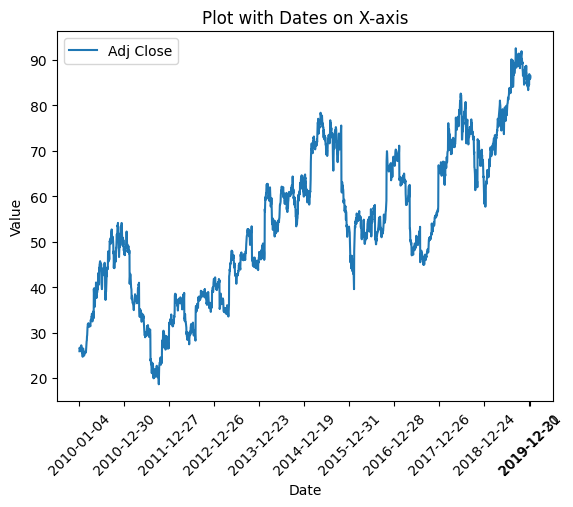

FTV


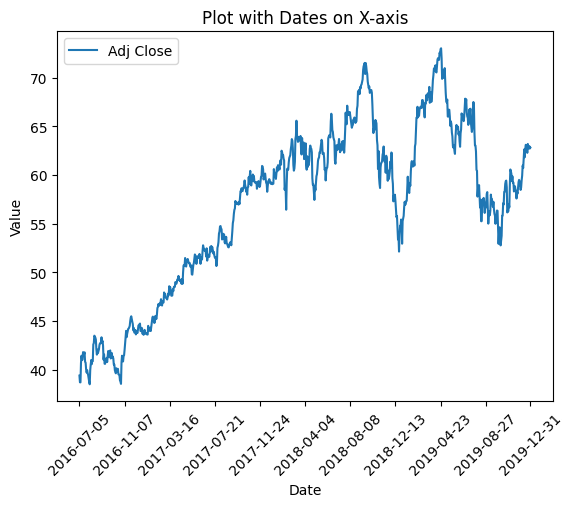

SYF


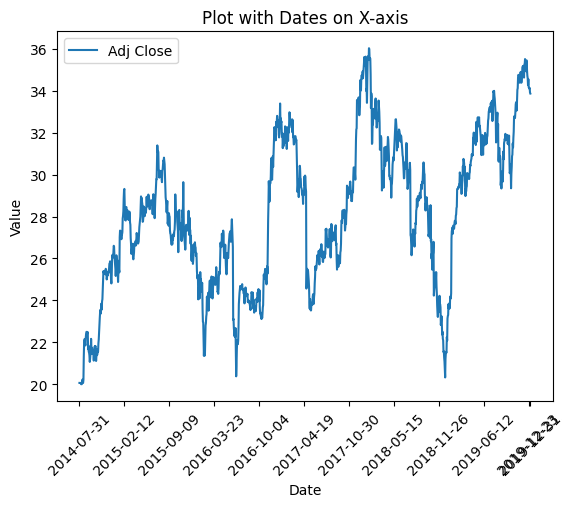

In [31]:
for stock in seasonal_stocks:
    print(stock)
    line_plot(df_train, stock, ["Adj Close"])

# EXPONENTIAL SMOOTHING

In [8]:
stock = "AKAM"
df_stock = df_train[df_train["Symbol"] == stock].reset_index(drop=True)
df_stock["Adj Close"].head()

0    25.920000
1    26.690001
2    26.469999
3    26.480000
4    26.480000
Name: Adj Close, dtype: float64

In [9]:
train_size = int(len(df_stock["Adj Close"]) * 0.7)

df_stock_train = df_stock["Adj Close"][:train_size]
df_stock_test = df_stock["Adj Close"][train_size:]

In [34]:
exp_smoothing_model = ExponentialSmoothing(df_stock_train, trend="additive", seasonal='additive', seasonal_periods=365)
fit = exp_smoothing_model.fit()

In [35]:
forecast = fit.forecast(len(df_stock_test))

rmse = np.sqrt(mean_squared_error(df_stock_test, forecast))
mae = mean_absolute_error(df_stock_test, forecast)

print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

Root Mean Square Error: 9.591138690868132
Mean Absolute Error: 7.462752962403756


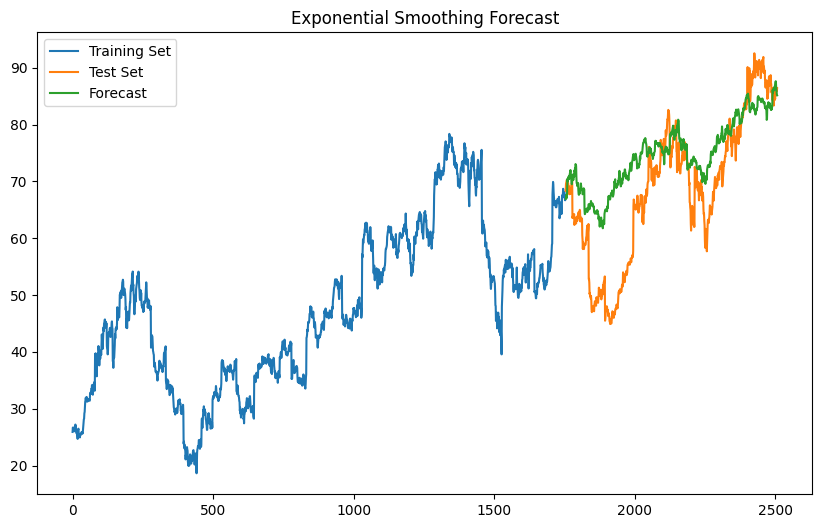

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(df_stock_train.index, df_stock_train, label='Training Set')
plt.plot(df_stock_test.index, df_stock_test, label='Test Set')
plt.plot(forecast.index, forecast, label='Forecast')
plt.legend(loc='best')
plt.title('Exponential Smoothing Forecast')
plt.show()

Obtained predictions are overall good, they show a really good prediction at the end (trend is predicted well), but don't work well with fluctuations.

In [37]:
exp_smoothing_model = ExponentialSmoothing(df_stock_train, trend="multiplicative", seasonal='multiplicative', seasonal_periods=365)
fit = exp_smoothing_model.fit()

forecast = fit.forecast(len(df_stock_test))

rmse = np.sqrt(mean_squared_error(df_stock_test, forecast))
mae = mean_absolute_error(df_stock_test, forecast)

print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

Root Mean Square Error: 8.492808660050343
Mean Absolute Error: 6.527861273875094


In [38]:
exp_smoothing_model = ExponentialSmoothing(df_stock_train, trend="additive", seasonal='multiplicative', seasonal_periods=365)
fit = exp_smoothing_model.fit()

forecast = fit.forecast(len(df_stock_test))

rmse = np.sqrt(mean_squared_error(df_stock_test, forecast))
mae = mean_absolute_error(df_stock_test, forecast)

print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

Root Mean Square Error: 8.556574102947424
Mean Absolute Error: 6.563122360390496


In [39]:
exp_smoothing_model = ExponentialSmoothing(df_stock_train, trend="multiplicative", seasonal='additive', seasonal_periods=365)
fit = exp_smoothing_model.fit()

forecast = fit.forecast(len(df_stock_test))

rmse = np.sqrt(mean_squared_error(df_stock_test, forecast))
mae = mean_absolute_error(df_stock_test, forecast)

print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

Root Mean Square Error: 9.107106822307266
Mean Absolute Error: 7.018794534834547


Exponential smoothing model with both trend and seasonal set as "multiplicative" works the best. That makes sense since it would be better to work with returns rather than prices of stocks. So here where we use  prices, multiplicative trend and seasonal make more sense.

# ARIMA

In [40]:
arima_model = ARIMA(df_stock_train, order=(0, 0, 0))
fit = arima_model.fit()

forecast = fit.forecast(steps=len(df_stock_test))

rmse = np.sqrt(mean_squared_error(df_stock_test, forecast))
mae = mean_absolute_error(df_stock_test, forecast)

print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

Root Mean Square Error: 24.81070522907093
Mean Absolute Error: 21.53505006699699


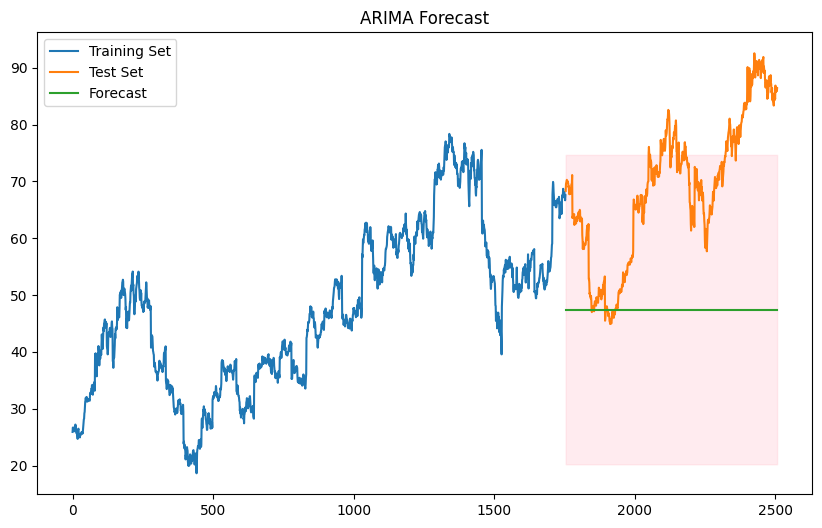

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(df_stock_train.index, df_stock_train, label='Training Set')
plt.plot(df_stock_test.index, df_stock_test, label='Test Set')
plt.plot(forecast.index, forecast, label='Forecast')

pred_conf = fit.get_forecast(steps=len(df_stock_test)).conf_int()
plt.fill_between(df_stock_test.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink', alpha=0.3)

plt.legend(loc='best')
plt.title('ARIMA Forecast')
plt.show()

Obtained predictions are useless because it's a straight line with a huge error. The width of the confidence interval suggests that the predictions model is very imprecise.

In [42]:
for p in range(5,46,5):
    arima_model = ARIMA(df_stock_train, order=(p, 0, 0))
    fit = arima_model.fit()

    forecast = fit.forecast(steps=len(df_stock_test))

    rmse = np.sqrt(mean_squared_error(df_stock_test, forecast))
    mae = mean_absolute_error(df_stock_test, forecast)
    
    print("p =", p)
    print("Root Mean Square Error:", rmse)
    print("Mean Absolute Error:", mae)

p = 5
Root Mean Square Error: 20.41906225876199
Mean Absolute Error: 17.357303286851952
p = 10
Root Mean Square Error: 20.372981976574156
Mean Absolute Error: 17.31843850927909
p = 15
Root Mean Square Error: 20.543111230157436
Mean Absolute Error: 17.44882647341993
p = 20
Root Mean Square Error: 20.57906702837462
Mean Absolute Error: 17.477003777478497
p = 25
Root Mean Square Error: 20.8739495612116
Mean Absolute Error: 17.71956414595
p = 30
Root Mean Square Error: 20.665304784407013
Mean Absolute Error: 17.55367734456769
p = 35
Root Mean Square Error: 19.815457818372707
Mean Absolute Error: 16.84865189098707
p = 40
Root Mean Square Error: 20.53563107013233
Mean Absolute Error: 17.4458175997831
p = 45
Root Mean Square Error: 19.254137858233438
Mean Absolute Error: 16.381920941363987


The best model here is the one with p=45.

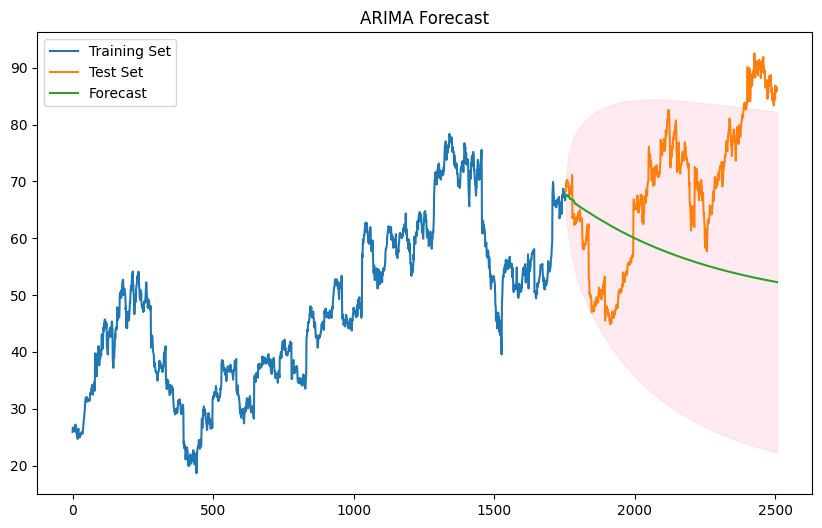

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(df_stock_train.index, df_stock_train, label='Training Set')
plt.plot(df_stock_test.index, df_stock_test, label='Test Set')
plt.plot(forecast.index, forecast, label='Forecast')

pred_conf = fit.get_forecast(steps=len(df_stock_test)).conf_int()
plt.fill_between(df_stock_test.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink', alpha=0.3)

plt.legend(loc='best')
plt.title('ARIMA Forecast')
plt.show()


Parameter p curved the prediction line and confidence interval.

In [44]:
for d in range(1,10):
    arima_model = ARIMA(df_stock_train, order=(0, d, 0))
    fit = arima_model.fit()

    forecast = fit.forecast(steps=len(df_stock_test))

    rmse = np.sqrt(mean_squared_error(df_stock_test, forecast))
    mae = mean_absolute_error(df_stock_test, forecast)
    
    print("d =", d)
    print("Root Mean Square Error:", rmse)
    print("Mean Absolute Error:", mae)

d = 1
Root Mean Square Error: 12.568261086223965
Mean Absolute Error: 10.314648343272419
d = 2
Root Mean Square Error: 381.3974998049951
Mean Absolute Error: 334.217405685915
d = 3
Root Mean Square Error: 159377.68394896033
Mean Absolute Error: 118932.13353993814
d = 4
Root Mean Square Error: 37532779.64650984
Mean Absolute Error: 24865186.592142746
d = 5
Root Mean Square Error: 9526880397.149666
Mean Absolute Error: 5726204139.871019
d = 6
Root Mean Square Error: 2914727739619.7188
Mean Absolute Error: 1614325483967.7058
d = 7
Root Mean Square Error: 768879830804746.5
Mean Absolute Error: 396936740783215.2
d = 8
Root Mean Square Error: 1.5249891578697325e+17
Mean Absolute Error: 7.402432751209762e+16
d = 9
Root Mean Square Error: 2.307730417307547e+19
Mean Absolute Error: 1.0604385463769596e+19


The best model here is the one with d=1.

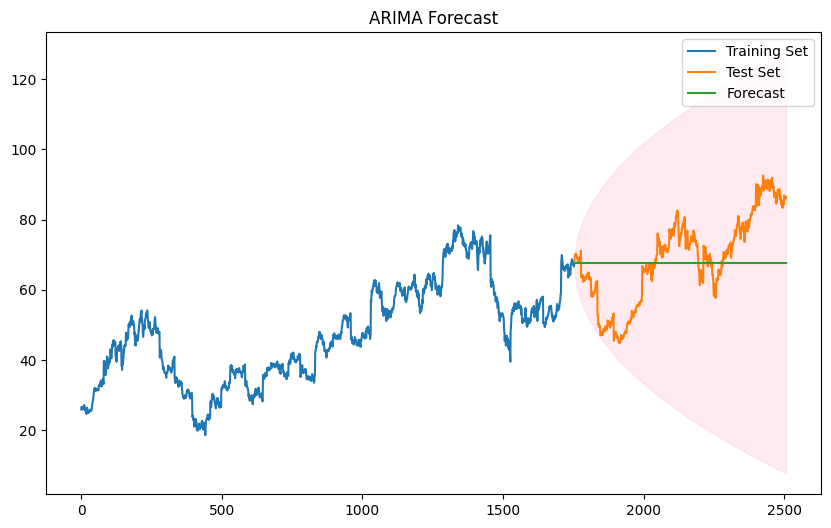

In [45]:
arima_model = ARIMA(df_stock_train, order=(0, 1, 0))
fit = arima_model.fit()

forecast = fit.forecast(steps=len(df_stock_test))

plt.figure(figsize=(10, 6))
plt.plot(df_stock_train.index, df_stock_train, label='Training Set')
plt.plot(df_stock_test.index, df_stock_test, label='Test Set')
plt.plot(forecast.index, forecast, label='Forecast')

pred_conf = fit.get_forecast(steps=len(df_stock_test)).conf_int()
plt.fill_between(df_stock_test.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink', alpha=0.3)

plt.legend(loc='best')
plt.title('ARIMA Forecast')
plt.show()

Parameter d curved only the confidence interval.

In [46]:
for q in range(5,50,5):
    arima_model = ARIMA(df_stock_train, order=(0, 0, q))
    fit = arima_model.fit()

    forecast = fit.forecast(steps=len(df_stock_test))

    rmse = np.sqrt(mean_squared_error(df_stock_test, forecast))
    mae = mean_absolute_error(df_stock_test, forecast)
    
    print("q =", q)
    print("Root Mean Square Error:", rmse)
    print("Mean Absolute Error:", mae)

q = 5
Root Mean Square Error: 24.766739053861915
Mean Absolute Error: 21.45929774415033
q = 10
Root Mean Square Error: 24.73350628732181
Mean Absolute Error: 21.4111175085299
q = 15
Root Mean Square Error: 24.69992572161228
Mean Absolute Error: 21.355408646173757
q = 20
Root Mean Square Error: 24.653427794064168
Mean Absolute Error: 21.27234335493023
q = 25
Root Mean Square Error: 24.651864879738042
Mean Absolute Error: 21.27744147921917
q = 30
Root Mean Square Error: 53.71555835376658
Mean Absolute Error: 28.18837698763301
q = 35
Root Mean Square Error: 24.591557154038142
Mean Absolute Error: 21.17540444300333
q = 40
Root Mean Square Error: 46.591644064609156
Mean Absolute Error: 28.147480131798208
q = 45
Root Mean Square Error: 24.458174935800812
Mean Absolute Error: 20.904550170857913


The best model here is the one with q=45, but for different q values, the results are similar.

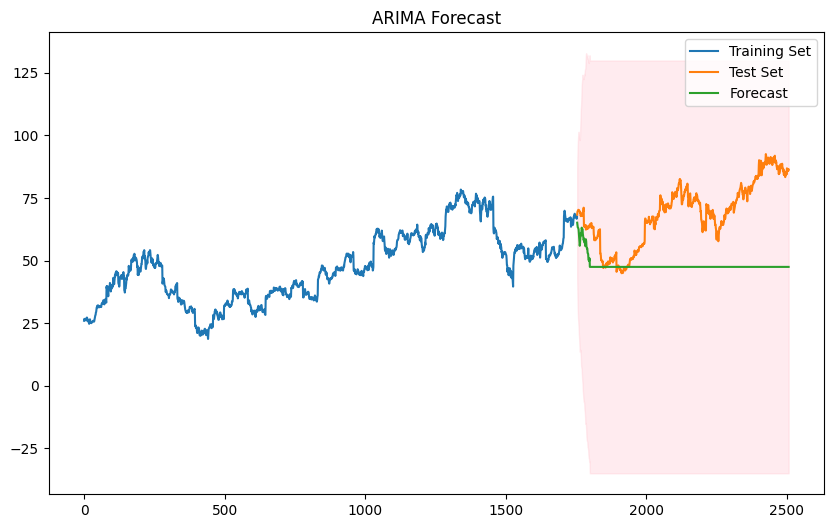

In [47]:
forecast = fit.forecast(steps=len(df_stock_test))

plt.figure(figsize=(10, 6))
plt.plot(df_stock_train.index, df_stock_train, label='Training Set')
plt.plot(df_stock_test.index, df_stock_test, label='Test Set')
plt.plot(forecast.index, forecast, label='Forecast')

pred_conf = fit.get_forecast(steps=len(df_stock_test)).conf_int()
plt.fill_between(df_stock_test.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink', alpha=0.3)

plt.legend(loc='best')
plt.title('ARIMA Forecast')
plt.show()

Parameter q changes beginning of the forecast line and beginning of the confidence interval, but later on its as if q equals 0.

In [58]:
best_p = [10, 45]
best_d = [1]
best_q = [5, 10, 20]

param_list = []

for p in best_p:
    for d in best_d:
        for q in best_q:
            arima_model = ARIMA(df_stock_train, order=(p, d, q))
            fit = arima_model.fit()

            forecast = fit.forecast(steps=len(df_stock_test))

            rmse = np.sqrt(mean_squared_error(df_stock_test, forecast))
            mae = mean_absolute_error(df_stock_test, forecast)
            
            param_list.append([p, d, q, rmse, mae])

In [59]:
df_params = pd.DataFrame(param_list, columns=["p", "d", "q", "RMSE", "MAE"])
print(df_params)

    p  d   q       RMSE        MAE
0  10  1   5  12.573532  10.321815
1  10  1  10  12.549667  10.287996
2  10  1  20  12.539287  10.273675
3  45  1   5  12.569618  10.312875
4  45  1  10  12.568860  10.313166
5  45  1  20  12.527712  10.255395


The best model is the one with parameters p=45, d=1 and q=20.

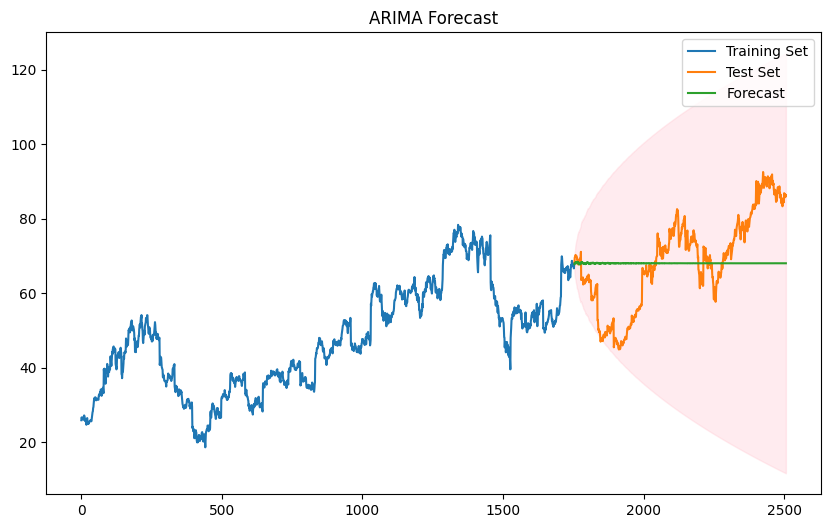

In [60]:
forecast = fit.forecast(steps=len(df_stock_test))

plt.figure(figsize=(10, 6))
plt.plot(df_stock_train.index, df_stock_train, label='Training Set')
plt.plot(df_stock_test.index, df_stock_test, label='Test Set')
plt.plot(forecast.index, forecast, label='Forecast')

pred_conf = fit.get_forecast(steps=len(df_stock_test)).conf_int()
plt.fill_between(df_stock_test.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink', alpha=0.3)

plt.legend(loc='best')
plt.title('ARIMA Forecast')
plt.show()

In [98]:
seasonalities = [60, 90, 365]
order = (10, 1, 10) #we take the simpler model (with a bit worse errors) to make optimization faster
for s in seasonalities:
    seasonal_order = (10, 1, 10, s)
    sarima_model = SARIMAX(df_stock_train, order=order, seasonal_order=seasonal_order)
    fit = sarima_model.fit()
    forecast = fit.forecast(steps=len(df_stock_test))

    rmse = np.sqrt(mean_squared_error(df_stock_test, forecast))
    mae = mean_absolute_error(df_stock_test, forecast)
    
    print("s =", s)
    print("Root Mean Square Error:", rmse)
    print("Mean Absolute Error:", mae)    

In [ ]:
forecast = fit.forecast(steps=len(df_stock_test))

plt.figure(figsize=(10, 6))
plt.plot(df_stock_train.index, df_stock_train, label='Training Set')
plt.plot(df_stock_test.index, df_stock_test, label='Test Set')
plt.plot(forecast.index, forecast, label='Forecast')

pred_conf = fit.get_forecast(steps=len(df_stock_test)).conf_int()
plt.fill_between(df_stock_test.index, pred_conf.iloc[:, 0], pred_conf.iloc[:, 1], color='pink', alpha=0.3)

plt.legend(loc='best')
plt.title('SARIMA Forecast')
plt.show()

# FACEBOOK PROPHET

In [10]:
df_stock_train_prophet = df_stock[["Date", "Adj Close"]][:train_size]
df_stock_test_prophet = df_stock[["Date", "Adj Close"]][train_size:]

df_stock_train_prophet.rename(columns={"Date": "ds", "Adj Close": "y"}, inplace=True)
df_stock_test_prophet.rename(columns={"Date": "ds", "Adj Close": "y"}, inplace=True)

In [11]:
model_prophet = Prophet()
model_prophet.fit(df_stock_train_prophet)

22:53:43 - cmdstanpy - INFO - Chain [1] start processing
22:53:44 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
future = model_prophet.make_future_dataframe(periods=365)
forecast = model_prophet.predict(future)

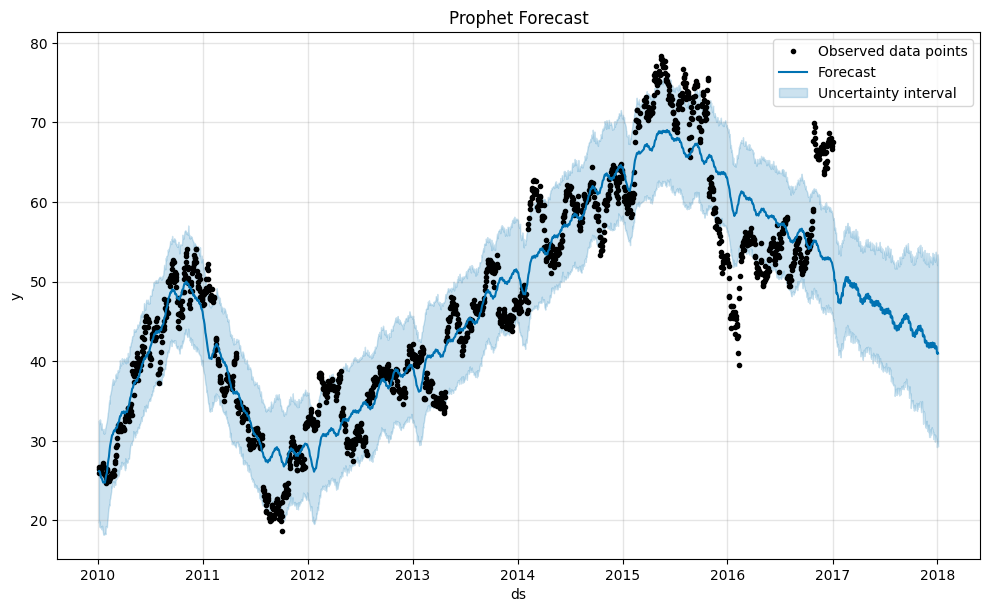

In [20]:
model_prophet.plot(forecast)
plt.legend(loc='best')
plt.title('Prophet Forecast')
plt.show()

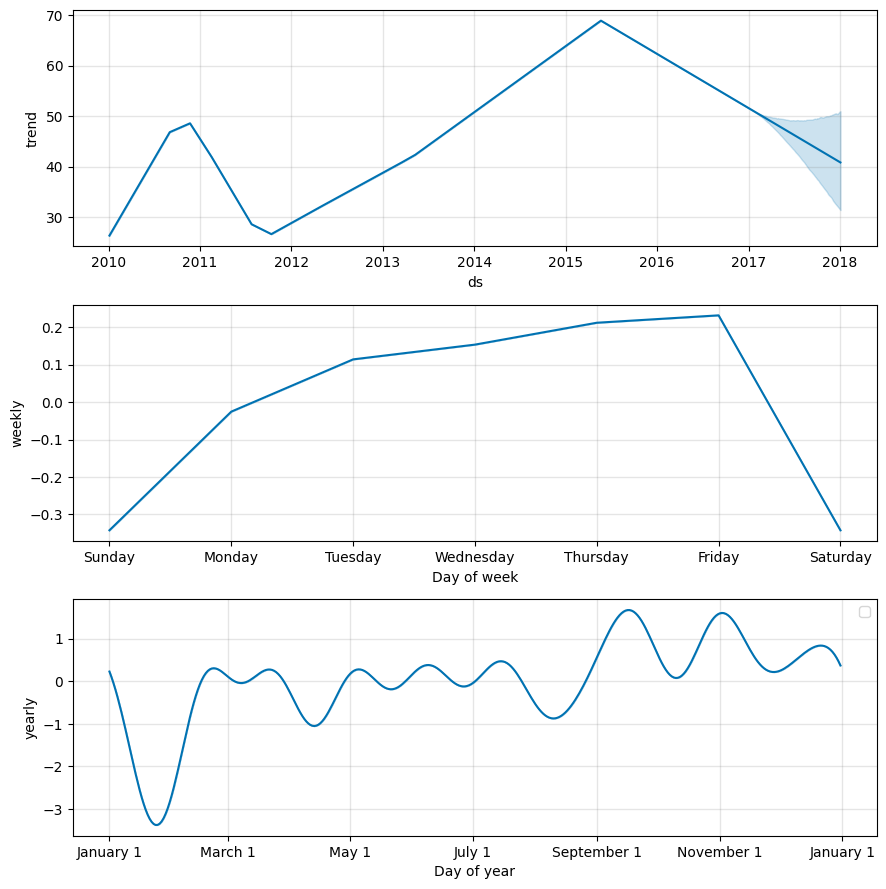

In [22]:
model_prophet.plot_components(forecast)
plt.legend(loc='best')
plt.show()

In [28]:
forecast_test = forecast[-len(df_stock_test_prophet):]

rmse = np.sqrt(mean_squared_error(df_stock_test_prophet['y'], forecast_test['yhat']))
mae = mean_absolute_error(df_stock_test_prophet['y'], forecast_test['yhat'])

print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

Root Mean Square Error: 24.704604151162776
Mean Absolute Error: 20.81211586424868


# RANDOM FOREST REGRESSOR

In [24]:
df_rfr = df_stock[["Adj Close"]]

lags = [1, 5, 10, 20, 30, 60, 90, 365]
for lag in lags:
    df_rfr[f"Lag {lag}"] = df_rfr["Adj Close"].shift(lag)

df_rfr = df_rfr.bfill()

X_train = df_rfr.drop(columns=["Adj Close"])[:train_size]
X_test = df_rfr.drop(columns=["Adj Close"])[train_size:]

y_train = df_rfr["Adj Close"][:train_size]
y_test = df_rfr["Adj Close"][train_size:]

In [26]:
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [27]:
forecast = model_rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, forecast))
mae = mean_absolute_error(y_test, forecast)

print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)  

Root Mean Square Error: 5.011809563487456
Mean Absolute Error: 2.9308127779916293


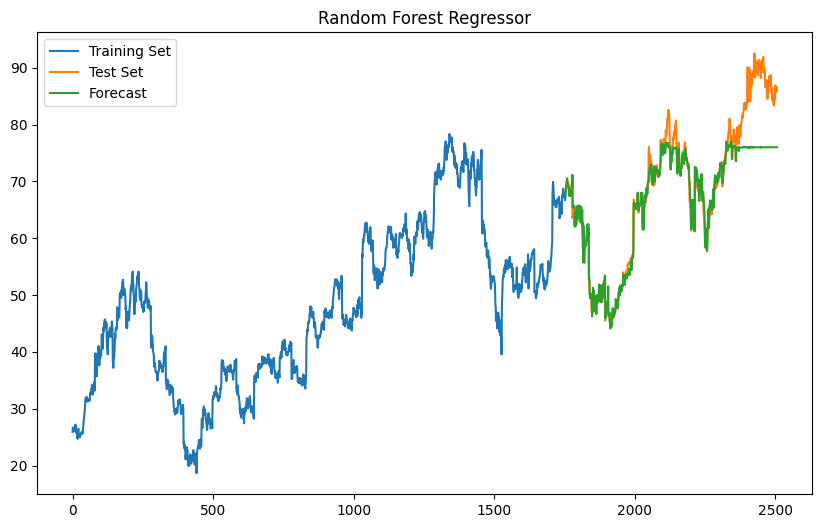

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Training Set')
plt.plot(y_test.index, y_test, label='Test Set')
plt.plot(y_test.index, forecast, label='Forecast')
plt.legend(loc='best')
plt.title('Random Forest Regressor')
plt.show()

This is the best model.

# GENERATED SIGNAL

In [4]:
t = np.linspace(0, 600, 600)
triangle1 = signal.sawtooth(2 * np.pi * 2 * 100 * t) 
triangle2 = signal.sawtooth(2 * np.pi * 2 * 28.57142857 * t, 0.63) 
trend = np.linspace(0, 600, 600)/(165*np.pi)
trend1 = np.linspace(0, 100, 100)/(112*np.pi)
trend2 = np.linspace(0, 300, 300)/(-103*np.pi)
trend3 = np.linspace(0, 200, 200)/(148*np.pi/2)
noise = np.random.normal(0,0.1056,600)
pts = triangle1 + triangle2 + trend + np.concatenate((trend1, trend2, trend3)) + noise

last_n_rows = 600
n_train_rows = 500

pts_train = pts[:-(last_n_rows-n_train_rows)]
pts_test = pts[-(last_n_rows-n_train_rows):]

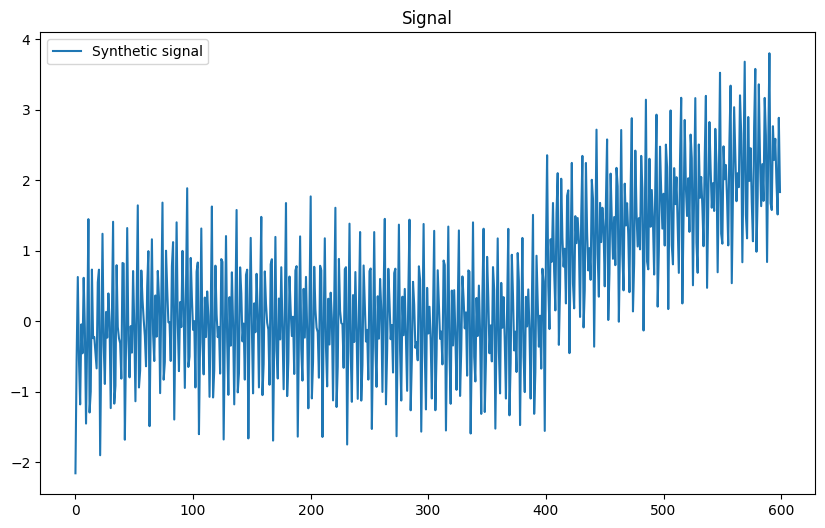

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(pts, label='Synthetic signal')
plt.legend(loc='best')
plt.title('Signal')
plt.show()

The generated signal consists of seasonality, trend and noise.
There is a signal periodicity because of the variables triangle1 and triangle2. There is also a trend in the signal caused by variables trend, trend1, trend2 and trend3.
Both are shown in the next graph.

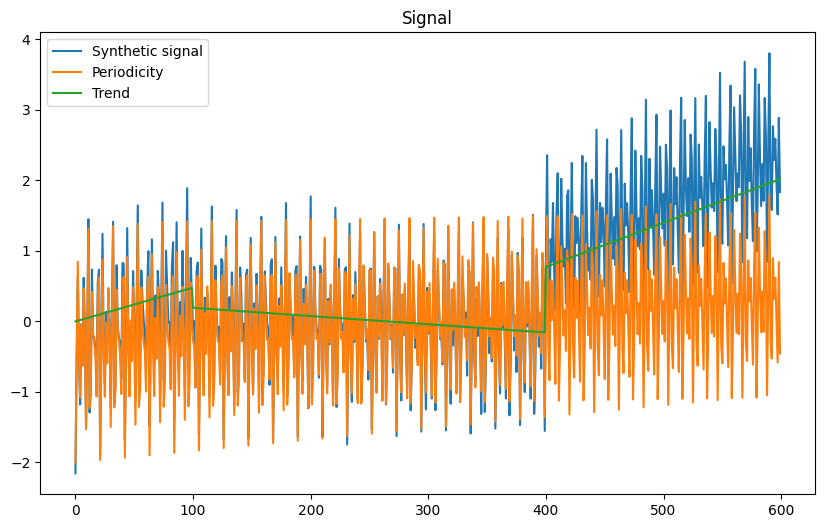

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(pts, label='Synthetic signal')
plt.plot(triangle1 + triangle2, label='Periodicity')
plt.plot(trend + np.concatenate((trend1, trend2, trend3)), label='Trend')
plt.legend(loc='best')
plt.title('Signal')
plt.show()

Trend is divided into 3 parts as expected due to the variables trend1, trend2 and trend3 which affected only a part of the whole signal.

In [13]:
peaks, _ = find_peaks(pts[:400], height=1)
peaks_dist = np.diff(t[peaks])

avg_period = np.mean(peaks_dist)

print("Signal periodicity is", avg_period)

Signal periodicity is 9.708488506485168


Now let's see if the previous models will forecast this signal well. 

In [19]:
index_train = []
index_test = []

for i in range(len(pts_train)):
    index_train.append(i)

for i in range(len(pts_test)):
    index_test.append(i+len(pts_train))

In [12]:
exp_smoothing_model = ExponentialSmoothing(pts_train)
fit = exp_smoothing_model.fit()

forecast = fit.forecast(len(pts_test))

rmse = np.sqrt(mean_squared_error(pts_test, forecast))
mae = mean_absolute_error(pts_test, forecast)

print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

Root Mean Square Error: 0.9695065500847371
Mean Absolute Error: 0.7906814150242143


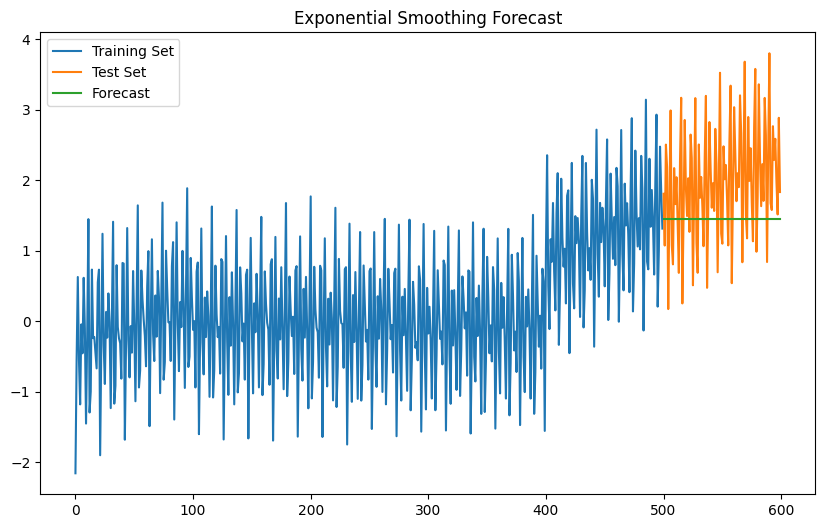

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(index_train, pts_train, label='Training Set')
plt.plot(index_test, pts_test, label='Test Set')
plt.plot(index_test, forecast, label='Forecast')
plt.legend(loc='best')
plt.title('Exponential Smoothing Forecast')
plt.show()

In [18]:
arima_model = ARIMA(pts_train, order=(10, 1, 10))
fit = arima_model.fit()

forecast = fit.forecast(steps=len(pts_test))

rmse = np.sqrt(mean_squared_error(pts_test, forecast))
mae = mean_absolute_error(pts_test, forecast)
    
print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

Root Mean Square Error: 0.5745406192890138
Mean Absolute Error: 0.48872211271142485


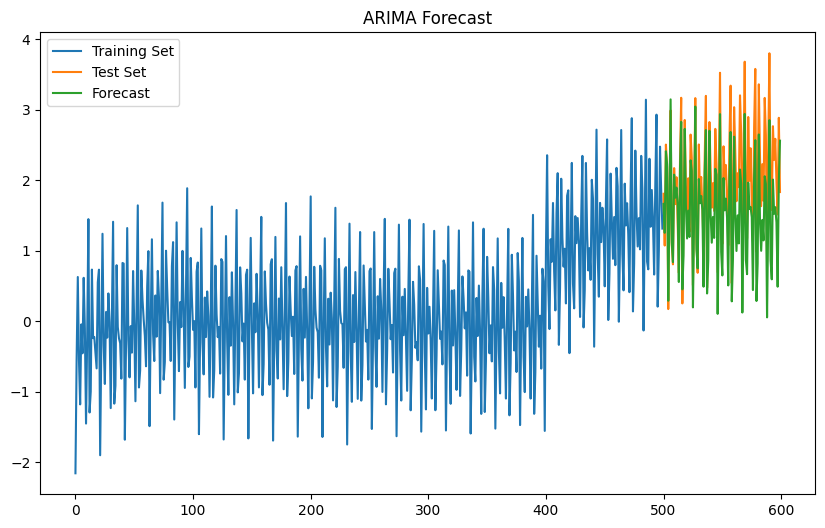

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(index_train, pts_train, label='Training Set')
plt.plot(index_test, pts_test, label='Test Set')
plt.plot(index_test, forecast, label='Forecast')

plt.legend(loc='best')
plt.title('ARIMA Forecast')
plt.show()

In [31]:
dates = pd.date_range(start='2000-01-01', periods=len(pts), freq='D')

df_pts = pd.DataFrame({'ds': dates, 'y': pts})

df_pts_train = df_pts[:-(last_n_rows-n_train_rows)]
df_pts_test = df_pts[-(last_n_rows-n_train_rows):]

In [33]:
model_prophet = Prophet()
model_prophet.fit(df_pts_train)

23:32:30 - cmdstanpy - INFO - Chain [1] start processing
23:32:30 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
future = model_prophet.make_future_dataframe(periods=len(df_pts_test))
forecast = model_prophet.predict(future)

forecast_test = forecast[-len(df_pts_test):]

rmse = np.sqrt(mean_squared_error(df_pts_test['y'], forecast_test['yhat']))
mae = mean_absolute_error(df_pts_test['y'], forecast_test['yhat'])

print("Root Mean Square Error:", rmse)
print("Mean Absolute Error:", mae)

Root Mean Square Error: 0.849936372417241
Mean Absolute Error: 0.692784402708925


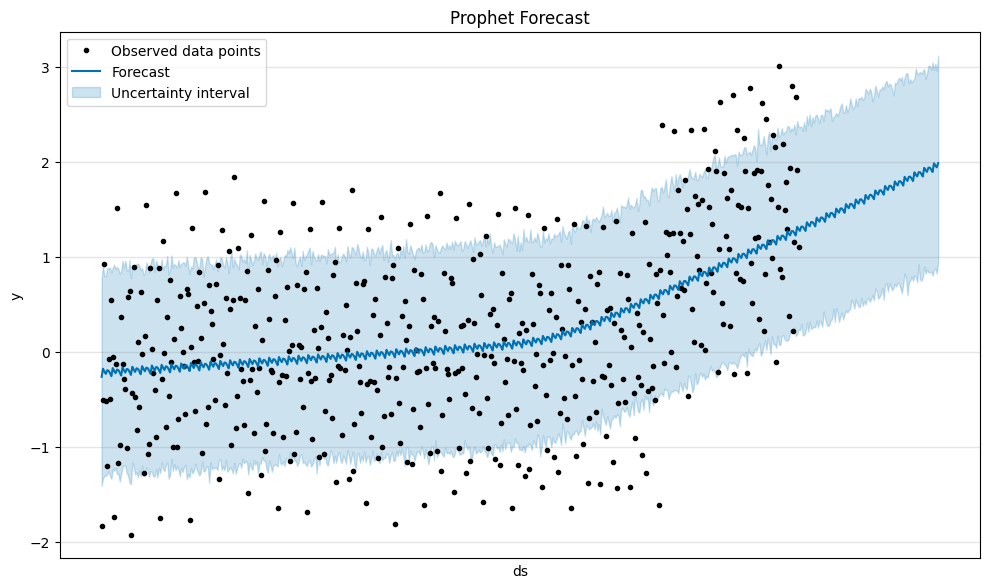

In [40]:
model_prophet.plot(forecast)
plt.xticks([])
plt.legend(loc='best')
plt.title('Prophet Forecast')
plt.show()